# starter notebook for people new to project to look at night's data

Helpful links:

https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from astropy.coordinates import SkyCoord
import astropy.units as u
import seaborn as sns

pd.set_option('display.max_rows', 10, 'display.max_columns', None, 'display.width', 200)

In [6]:
# load an example night of alerts from June 2, 2023.

testnight = pd.read_parquet('./example_data/2460097.5_2460098.5_1_2_3.parquet' )

In [3]:
#some active filters are testing something specfic, or arent actually used and should be removed from analysis

def remove_filters(arr):
    if arr.size == 0: 
        return arr
    remove_values = {20, 55, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 79, 81, 89, 90, 
                     100, 102, 103, 106, 1159, 1162, 1163, 1164, 1168, 1181} 
    mask = np.vectorize(lambda x: x not in remove_values)(arr)
    return arr[mask]

testnight['passed_filters'] = testnight['passed_filters'].apply(remove_filters)

In [4]:
# add some commonly considered or useful for analysis parameters 

def parameter_modifications(df):
    # add age parameter
    df['age'] = df["candidate.jd"] - df["candidate.jdstarthist"]
    df['lastobs'] = df['candidate.jd'] - df['candidate.jdendhist']

    #use ra and dec to get galactic latitude
    ra = df['candidate.ra']    
    dec = df['candidate.dec']
    coords = SkyCoord(ra=ra.values * u.degree, dec=dec.values * u.degree, frame='icrs')
    galactic_coords = coords.galactic
    galactic_latitudes = galactic_coords.b.deg
    df['galactic_latitude'] = galactic_latitudes

    # add some values related to filtering
    df['filtered_bool'] = df['passed_filters'].apply(lambda x: 0 if len(x) == 0 else 1)
    df['number_filtered'] = df['passed_filters'].apply(len)
    
    return df

testnight = parameter_modifications(testnight)

In [5]:
# cut to select parameters we are interested in

# remove some columns from consideration
ignore = ['objectId', 'candid', 'candidate.jd', 'candidate.pid', 'candidate.programid', 'candidate.tblid', 'candidate.nid',
            'candidate.rcid', 'candidate.field', 'candidate.xpos', 'candidate.ypos', 'candidate.rbversion', 'candidate.drbversion', 
            'candidate.ssnamenr', 'candidate.ranr', 'candidate.decnr', 'candidate.tooflag', 'candidate.objectidps1', 'candidate.objectidps2',
            'candidate.objectidps3', 'candidate.rfid', 'candidate.jdstartref', 'candidate.jdendref', 'candidate.nframesref', 
            'classifications.braai_version', 'classifications.acai_h_version', 'classifications.acai_v_version', 
            'classifications.acai_o_version', 'classifications.acai_n_version', 'classifications.acai_b_version',
              'classifications.bts_version', 'candidate.jdstarthist', 'candidate.jdendhist', 'candidate.ra', 'candidate.dec',
            ]

testnight = testnight.drop(columns=[col for col in ignore if col in testnight.columns])

In [6]:
#remove candidate and classifications from column names
testnight.columns = testnight.columns.str.replace(r'^candidate\.', '', regex=True)
testnight.columns = testnight.columns.str.replace(r'^classifications\.', '', regex=True)

In [7]:
testnight

,fid,diffmaglim,isdiffpos,magpsf,sigmapsf,chipsf,magap,sigmagap,distnr,magnr,sigmagnr,chinr,sharpnr,sky,magdiff,fwhm,classtar,mindtoedge,magfromlim,seeratio,aimage,bimage,aimagerat,bimagerat,elong,nneg,nbad,rb,ssdistnr,ssmagnr,sumrat,magapbig,sigmagapbig,sgmag1,srmag1,simag1,szmag1,sgscore1,distpsnr1,ndethist,ncovhist,scorr,sgmag2,srmag2,simag2,szmag2,sgscore2,distpsnr2,sgmag3,srmag3,simag3,szmag3,sgscore3,distpsnr3,nmtchps,dsnrms,ssnrms,dsdiff,magzpsci,magzpsciunc,magzpscirms,nmatches,clrcoeff,clrcounc,zpclrcov,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,braai,acai_h,acai_v,acai_o,acai_n,acai_b,bts,passed_filters,age,lastobs,galactic_latitude,filtered_bool,number_filtered
0,2,18.626341,t,16.799009,0.051099,7.558737,16.994101,0.0840,0.275864,15.292999,0.015,0.791,-0.038,9.542685,0.195091,2.350000,0.998,100.579002,1.632241,1.115457,0.788,0.682,0.335319,0.290213,1.155425,6,0,0.588571,-999.0,-999.0,0.961145,16.975000,0.1051,15.7000,15.271100,14.929000,14.882400,0.997083,0.318585,1274,1935,5.673564,21.732000,21.417601,21.011101,20.655701,0.799723,12.027080,21.700800,20.969700,20.859600,-999.000000,0.022917,14.445962,6,12.132607,33.773430,-21.640823,26.020008,0.000014,0.051915,966,0.101796,0.000027,-0.000018,26.082001,0.589,0.273511,0.318172,-999.000000,15.252001,-999.000000,30.0,0.999892,9.595336e-01,1.238939e-09,9.530645e-01,0.000000e+00,1.116127e-02,0.000022,0.000321,[],2051.638137,0.0,23.048237,0,0
1,2,18.811831,t,18.841064,0.208028,2.449184,18.444901,0.2660,4.009125,22.143000,0.136,0.539,-0.057,1.810715,-0.396165,3.120000,0.998,794.507812,0.366930,0.832410,1.497,1.014,0.479808,0.325000,1.476331,3,0,0.161429,-999.0,-999.0,1.000000,18.433201,0.3380,21.4755,21.874701,21.247801,20.646601,0.006875,4.481011,1,3738,7.858052,-999.000000,22.000200,20.650999,19.962000,0.945827,27.669449,21.605600,21.458000,-999.000000,-999.000000,0.500000,27.806879,5,4.672199,7.954886,-3.282688,26.043064,0.000012,0.049588,901,0.098967,0.000021,-0.000015,26.104000,0.639,0.294528,55.337288,-999.000000,20.264154,-999.000000,30.0,0.000472,1.458990e-02,2.514416e-03,1.604352e-05,4.018809e-01,7.107591e-05,0.956138,0.107194,[],0.000000,0.0,26.552805,0,0
2,2,18.811831,f,18.958065,0.212635,1.378804,18.669500,0.3266,5.294755,22.540001,0.259,0.940,-0.418,12.002670,-0.288565,3.350000,1.000,91.638000,0.142330,0.775260,1.017,0.864,0.303582,0.257910,1.177083,6,0,0.468571,-999.0,-999.0,0.977335,18.678699,0.4234,21.7054,21.511000,20.803600,20.308901,0.026000,14.526670,1,1900,7.960929,-999.000000,-999.000000,21.494301,-999.000000,0.032833,21.389425,19.148300,18.635401,18.286800,18.203199,0.001667,24.087730,5,3.355927,7.851953,-4.496026,26.043064,0.000012,0.049588,901,0.098967,0.000021,-0.000015,26.104000,0.639,0.294528,45.548149,-999.000000,18.408741,-999.000000,30.0,0.195881,3.606397e-01,3.167244e-09,5.704186e-06,7.866788e-02,1.338359e-05,0.979516,0.062876,[],0.000000,0.0,26.837981,0,0
3,2,18.811831,t,19.110065,0.205193,1.270712,19.505800,0.7056,3.693708,23.320000,0.345,0.390,-0.301,-5.285373,0.395735,1.298560,0.981,523.493103,-0.693970,2.000000,0.580,0.500,0.446649,0.385042,1.160000,5,0,0.471429,-999.0,-999.0,1.000000,19.317200,0.7623,21.8246,21.928301,21.206301,-999.000000,0.457253,3.704674,1,2035,6.155668,16.629801,16.336399,16.235300,16.231600,0.992708,15.220973,16.915199,16.487400,16.253099,16.198500,0.882363,15.222513,9,4.615822,5.923193,-1.307371,26.043064,0.000012,0.049588,901,0.098967,0.000021,-0.000015,26.104000,0.639,0.294528,15.199573,87.249275,16.425869,12.444607,30.0,0.999886,9.984368e-01,2.889619e-02,2.429167e-02,7.809982e-01,1.716967e-04,0.001445,0.121514,[],0.000000,0.0,26.326614,0,0
4,2,18.935961,t,17.003948,0.036270,3.254369,17.067499,0.0686,8.785863,22.549999,0.339,1.526,0.185,-0.293050,0.063552,2.910000,0.985,396.726807,1.868460,0.873903,0.707,0.678,0.242955,0.232990,1.042773,2,0,0.861429,2.0,17.5,1.000000,17.145300,0.0944,-999.0000,22.201700,21.128201,-999.000000,0.251869,8.307606,1,1918,30.984989,-999.000000,21.948

# starter visualizations

In [10]:
from frigate_plots import HistogramPlotter, ViolinPlotter, ScatterPlotter, CornerPlotter, PairPlotter

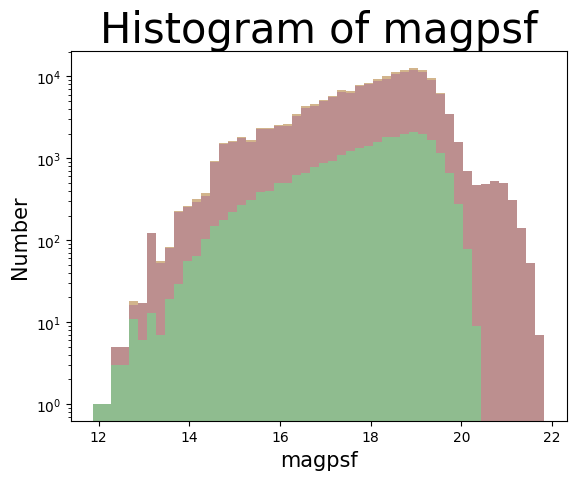

In [9]:
plotter = HistogramPlotter(testnight)
plotter.histogram('magpsf', log=True)

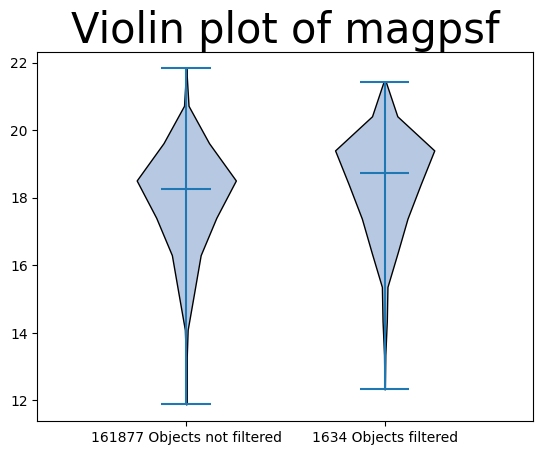

In [10]:
# violins

plotter = ViolinPlotter(testnight)
plotter.violin('magpsf')

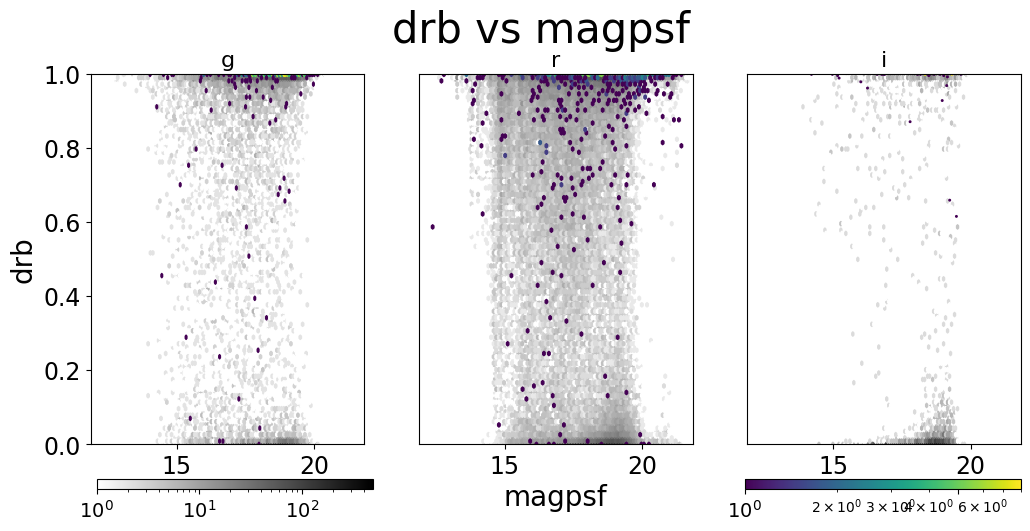

In [11]:
plotter = ScatterPlotter(testnight)
plotter.scatter('magpsf', 'drb')

Column 'magnr' has 8 negative values
Column 'szmag1' has 8428 negative values


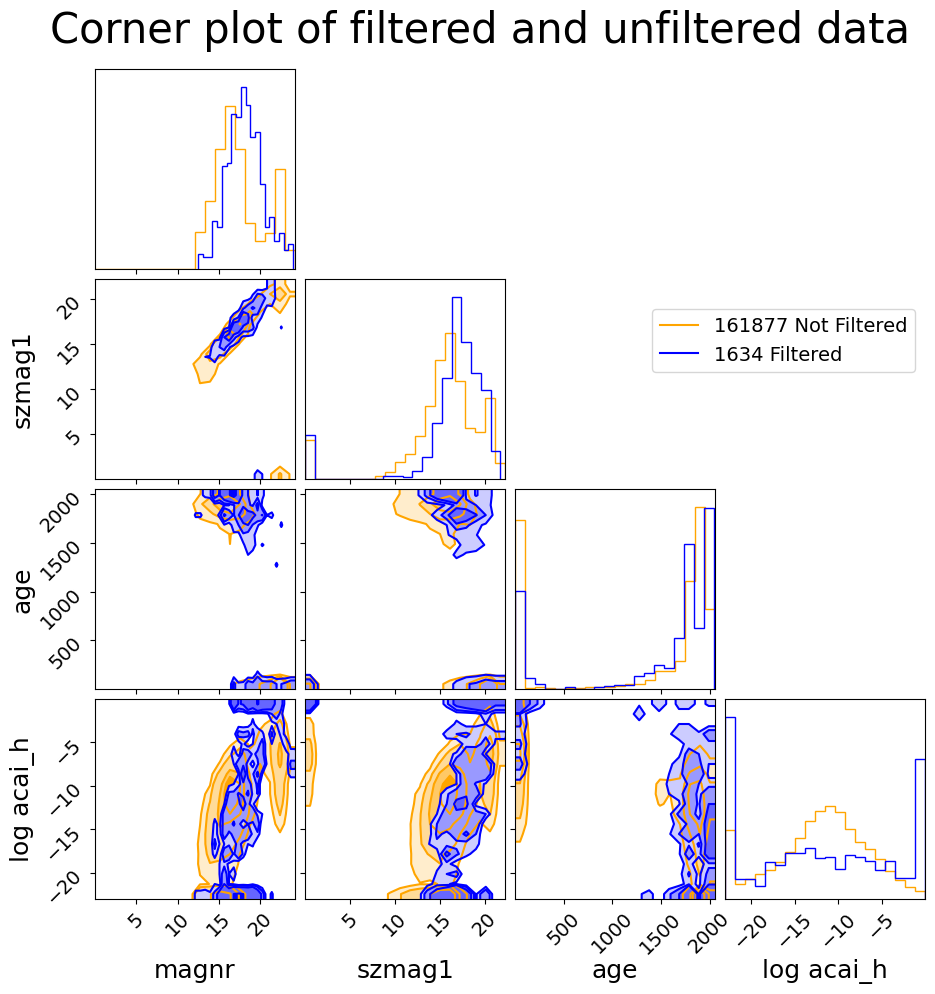

In [12]:
# corner plots

# include filtered_bool for color coding
features = ['magnr', 'szmag1', 'age', 'acai_h', 'filtered_bool']
# features to put a log scale on
log = ['acai_h']

plotter = CornerPlotter(testnight)
plotter.cornerplot(features, log)

In [ ]:
features = ['magnr', 'magpsf', 'age', 'acai_v', 'filtered_bool']

plotter = PairPlotter(testnight)
plotter.pairplot(testnight, features)